# TD2C Validation on Real-World Data

This notebook is designed to validate the `TD2C` method on real-world datasets of varying sizes and compositions. The primary goals are to:

1. **Validate on Real-World Datasets**: Apply the `TD2C` method to datasets that differ in size and composition to assess its robustness and effectiveness in practical scenarios.

2. **Model Training Comparison**: Evaluate the performance of the `TD2C` method when trained on models with different process characteristics:
   - **Linear-Only Training**: Validate the method using a model trained exclusively on linear processes.
   - **Mixed Training (Linear and Nonlinear)**: Assess the method using a model equally trained on both linear and nonlinear processes.
   
3. **Performance Comparison**: Compare the results from the different training approaches to determine under which circumstances the `TD2C` estimates perform better, particularly focusing on their application to real-world data.

By the end of this notebook, users will have a clear understanding of how the `TD2C` method performs in various real-world contexts, and will be equipped to apply the method effectively in both linear and nonlinear data environments.


# Settings

### Load Packages

In [3]:
import pickle
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
import joblib

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

from d2c.benchmark import D2CWrapper

from d2c.descriptors_generation.loader import DataLoader

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


### Set Parameters

In [4]:
# PARAMETERS
N_JOBS = 40 # number of jobs to run in parallel. For D2C, parallelism is implemented at the observation level: each observation from a single file is processed in parallel
SEED = 42 # random seed
all_metrics = {}

# Model Training

### Train the models

In [108]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/train_data/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/decriptors/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)


models = {}
mode = 'LOPOCV_mixture'
# 'LOPOCV_all' = train the model on all processes except the one
# 'combined_all' = train the model on all processes combined
# 'LOPOCV_lin' = train the model on processes 18, 19 and 20 separately
# 'combined_lin' = train the model on processes 18, 19 and 20 combined and test on the rest
# 'LOPOCV_mixture' = train the model on processes 18, 19 and 20 and 3 nonlinear processes separately
# 'combined_mixture' = train the model on processes 18, 19 and 20 and 3 nonlinear processes combined

# Define the processes you're using for training
all_processes = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
subset_lin = [18, 19, 20]
subset_mixture = [18, 19, 20, 1, 6, 15]

if mode == 'LOPOCV_all':
    processes = all_processes
elif mode == 'combined_all':
    processes = all_processes
elif mode == 'LOPOCV_lin':
    processes = subset_lin
elif mode == 'combined_lin':
    processes = subset_lin
elif mode == 'LOPOCV_mixture':
    processes = subset_mixture
elif mode == 'combined_mixture':
    processes = subset_mixture

descriptors_train = descriptors_training[descriptors_training['process_id'].isin(processes)]
print(f'CONSIDERED PROCESS {processes}')
print(descriptors_train['process_id'].unique())

if mode == 'LOPOCV_all' or mode == 'LOPOCV_lin' or mode == 'LOPOCV_mixture':
    for process in tqdm(processes):
        training_data = descriptors_train[descriptors_train['process_id'] != process]

        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size', 'noise_std', 'edge_source', 'edge_dest', 'is_causal'])
        y_train = training_data['is_causal']

        # Train the model
        model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=N_JOBS, max_depth=None, bootstrap=False)
        model.fit(X_train, y_train)

        models[process] = model
    
elif mode == 'combined_all' or mode == 'combined_lin' or mode == 'combined_mixture':
    training_data = descriptors_train

    X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size', 'noise_std', 'edge_source', 'edge_dest', 'is_causal'])
    y_train = training_data['is_causal']

    # Train the model
    model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=N_JOBS, max_depth=None, bootstrap=False)
    model.fit(X_train, y_train)

    # Save the model
    pickle.dump(model, open(f'/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/models/RF_model_for_{mode}_processes.pkl', 'wb'))


    
if mode == 'LOPOCV_all' or mode == 'LOPOCV_lin' or mode == 'LOPOCV_mixture':
    from sklearn.ensemble import VotingClassifier

    # Assuming your models are classifiers, create an ensemble
    estimators = []
    for model in models:
        estimators.append((f'model_{model}', models[model]))

    ensemble_model = VotingClassifier(estimators, voting='soft')  # 'soft' for averaging probabilities

    # Use the ensemble to predict
    ensemble_model.fit(X_train, y_train)

    # Save the model
    pickle.dump(ensemble_model, open(f'/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/models/RF_ensemble_model_for_{mode}_processes.pkl', 'wb'))



CONSIDERED PROCESS [18, 19, 20, 1, 6, 15]
[15 18 19  1 20  6]


100%|██████████| 6/6 [00:01<00:00,  3.10it/s]


### Load Trained Models

In [3]:
# full model 
model_all_combined = pickle.load(open(f'/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/models/RF_model_for_combined_all_processes.pkl', 'rb'))
model_lin_combined = pickle.load(open(f'/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/models/RF_model_for_combined_lin_processes.pkl', 'rb'))
model_mixture_combined = pickle.load(open(f'/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/models/RF_model_for_combined_mixture_processes.pkl', 'rb'))
model_all_LOPOCV = pickle.load(open(f'/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/models/RF_ensemble_model_for_LOPOCV_all_processes.pkl', 'rb'))
model_lin_LOPOCV = pickle.load(open(f'/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/models/RF_ensemble_model_for_LOPOCV_lin_processes.pkl', 'rb'))
model_mixture_LOPOCV = pickle.load(open(f'/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/models/RF_ensemble_model_for_LOPOCV_mixture_processes.pkl', 'rb'))

# HYBRID PAPER DATA:

## Antivirus activity

Impacts of antivirus activity in servers.
13 time series such that 3 of them are collected with a one-minute sampling rate and the rest with a five-minute sampling rate.

The two processed datasets consist of 1321 timestamps:
  - preprocessed 1
  - preprocessed 2
  
  ### Ground truth:
  - memory_usage_Portal -> Physical_Memory_prct_used_Portal
  - cpu_usage_Portal -> cpu_prct_used_Portal
  - Physical_Memory_prct_used_Portal -> 0_C_read_Portal
  - cpu_prct_used_Portal -> 0_C_read_Portal
  - memory_usage_VDI -> Physical_Memory_prct_used_VDI
  - cpu_usage_VDI -> cpu_prct_used_VDI
  - Physical_Memory_prct_used_VDI -> 0_C_read_VDI
  - cpu_prct_used_VDI -> 0_C_read_VDI
  - Physical_Memory_prct_used_Portal -> Chargement_portail
  - cpu_prct_used_Portal -> Chargement_portail
  - 0_C_read_Portal -> Chargement_portail
  - Physical_Memory_prct_used_VDI -> Chargement_IE
  - cpu_prct_used_VDI -> Chargement_IE
  - 0_C_read_VDI -> Chargement_IE
  - Chargement_portail -> Default_Transaction
  - Chargement_IE -> Default_Transaction

### Load Data

In [4]:
ts_1 = np.loadtxt('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/preprocessed_1.txt', delimiter=',',skiprows=1)
ts_2 = np.loadtxt('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/preprocessed_2.txt', delimiter=',',skiprows=1)
ts_1_df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/preprocessed_1.txt')
ts_2_df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/preprocessed_2.txt')
results_antivirus = {f'model_all_combined score': None, f'model_lin_combined score': None, f'model_mixture_combined score': None, f'model_all_LOPOCV score': None, f'model_lin_LOPOCV score': None, f'model_mixture_LOPOCV score': None}
metrics = {}

# save to pickle ts1 and ts2
ts_1_df.to_pickle('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/pikles/preprocessed_1.pkl')
ts_2_df.to_pickle('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/pikles/preprocessed_2.pkl')


### Run competitors

In [5]:
# load data from pkl
data_root = '/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/pikles/'
from d2c.benchmark.pcmci import PCMCI
from d2c.benchmark.granger import Granger
from d2c.benchmark.dynotears import DYNOTEARS
from d2c.benchmark.varlingam import VARLiNGAM



# ts_1 as toople
ts_1_touple = (ts_1, ts_1)

pcmci = PCMCI(ts_list=ts_1_touple, maxlags=1, n_jobs=40, ci="ParCorr")
pcmci.run()
causal_dfs_pcmci = pcmci.get_causal_dfs()

granger = Granger(ts_list=ts_1_touple, maxlags=1, n_jobs=40)
granger.run()
causal_dfs_granger = granger.get_causal_dfs()

dynotears = DYNOTEARS(ts_list=ts_1_touple, maxlags=1, n_jobs=N_JOBS)
dynotears.run()
causal_dfs_dynotears = dynotears.get_causal_dfs()

varlingam = VARLiNGAM(ts_list=ts_1_touple, maxlags=1, n_jobs=N_JOBS)
varlingam.run()
causal_dfs_varlingam = varlingam.get_causal_dfs()


/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/causalnex/structure/dynotears.py:487: UserWarning: Failed to converge. Consider increasing max_iter.
  warnings.warn("Failed to converge. Consider increasing max_iter.")
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/causalnex/structure/dynotears.py:487: UserWarning: Failed to converge. Consider increasing max_iter.
  warnings.warn("Failed to converge. Consider increasing max_iter.")


### Get Causal DF and manipulate it

In [6]:
MODEL = model_all_LOPOCV
# model_all_combined: model trained on all processes combined
# model_lin_combined: model trained on linear processes combined
# model_mixture_combined: model trained on linear and nonlinear processes combined
# model_all_LOPOCV: ensemble model trained on all processes except the one
# model_lin_LOPOCV: ensemble model trained on linear processes except the one
# model_mixture_LOPOCV: ensemble model trained on linear and nonlinear processes except the one

ts = ts_1
n_variables = ts.shape[1]
# ts_1: Antivirus_activity_1
# ts_2: Antivirus_activity_2


d2cwrapper = D2CWrapper(ts_list=[ts], 
                        n_variables=13, 
                        model=MODEL, 
                        maxlags=1, 
                        n_jobs=40, 
                        full=True, 
                        quantiles=True,
                        filename='d2c_results',
                        normalize=True, 
                        cmi='original', 
                        mb_estimator='ts')

d2cwrapper
d2cwrapper.run()
causal_df_td2c = d2cwrapper.get_causal_dfs()
causal_df_td2c

/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/ensemble/_base.py:214: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/ensemble/_base.py:214: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/ensemble/_base.py:214: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/ensemble/_base.py:214: UserWarning: Loky-backed parallel loops cannot be called in a multiprocessing, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/home/jpalombarini/td2c/myen

{0:      from  to effect p_value  probability  is_causal
 0      23   4   None    None         0.19      False
 1      17   3   None    None         0.17      False
 2      19   0   None    None         0.09      False
 3      17  12   None    None         0.12      False
 4      19   9   None    None         0.26      False
 ..    ...  ..    ...     ...          ...        ...
 164    15   3   None    None         0.27      False
 165    15  12   None    None         0.20      False
 166    16  11   None    None         0.15      False
 167    18   8   None    None         0.21      False
 168    21   7   None    None         0.15      False
 
 [169 rows x 6 columns]}

In [73]:
# PRINT DATAFRAME WITH CAUSAL RELATIONSHIPS
# causal_df = causal_dfs_granger
# causal_df = causal_dfs_pcmci
# causal_df = causal_dfs_dynotears
# causal_df = causal_dfs_varlingam
causal_df = causal_df_td2c

df = causal_df[0]
# order df by 'from' and 'by' columns
df = df.sort_values(by=['from', 'to'])

df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/results/causal_df.csv', index=False)

df

,from,to,effect,p_value,probability,is_causal
79,13,0,None,None,0.26,False
16,13,1,None,None,0.22,False
94,13,2,None,None,0.24,False
30,13,3,None,None,0.20,False
110,13,4,None,None,0.27,False
...,...,...,...,...,...,...
86,25,8,None,None,0.22,False
151,25,9,None,None,0.21,False
99,25,10,None,None,0.19,False
39,25,11,None,None,0.16,False


### perform 

In [85]:
# RELEVEL FROM AND TO COLUMNS WITH THE RIGHT NODES NAMES

import pandas as pd

# Assuming df is your DataFrame

# Step 1: Get the unique levels
from_levels = df['from'].unique()
to_levels = df['to'].unique()

# Step 2: Create mapping dictionaries
from_mapping = {level: i+1 for i, level in enumerate(from_levels)}
to_mapping = {level: i+1 for i, level in enumerate(to_levels)}

# Step 3: Apply the mapping to the columns
df['from'] = df['from'].map(from_mapping)
df['to'] = df['to'].map(to_mapping)

# Display the result
df


,from,to,effect,p_value,probability,is_causal
79,1,1,None,None,0.26,False
16,1,2,None,None,0.22,False
94,1,3,None,None,0.24,False
30,1,4,None,None,0.20,False
110,1,5,None,None,0.27,False
...,...,...,...,...,...,...
86,13,9,None,None,0.22,False
151,13,10,None,None,0.21,False
99,13,11,None,None,0.19,False
39,13,12,None,None,0.16,False


In [86]:
# show only df rows that have 'is_causal' == True
df[df['is_causal'] == True]

,from,to,effect,p_value,probability,is_causal


In [87]:
# LOAD DATA AS DATAFRAME
ts_df = ts_1_df
# ts_1_df: Antivirus_activity_1
# ts_2_df: Antivirus_activity_2

# list the names in the first row
names = ts_df.columns

# associate a number to each name
name_to_number = {name: i+1 for i, name in enumerate(names)}

name_to_number

{'memory_usage_Portal': 1,
 'cpu_usage_Portal': 2,
 'Physical_Memory_prct_used_Portal': 3,
 'cpu_prct_used_Portal': 4,
 '0_C_read_Portal': 5,
 'memory_usage_VDI': 6,
 'cpu_usage_VDI': 7,
 'Physical_Memory_prct_used_VDI': 8,
 'cpu_prct_used_VDI': 9,
 '0_C_read_VDI': 10,
 'Chargement_portail': 11,
 'Chargement_IE': 12,
 'Default_Transaction': 13}

In [88]:
# take only the columns 'from', 'to' for a certain probability threshold
caus = df[df['probability'] > 0.2][['from', 'to']]
non_caus = df[df['probability'] <= 0.2][['from', 'to']]
# caus = df[df['is_causal'] == 1][['from', 'to']]
# non_caus = df[df['is_causal'] == 0][['from', 'to']]


number_to_name = {v: k for k, v in name_to_number.items()}

# apply the mapping
caus['from'] = caus['from'].replace(number_to_name)
caus['to'] = caus['to'].replace(number_to_name)

non_caus['from'] = non_caus['from'].replace(number_to_name)
non_caus['to'] = non_caus['to'].replace(number_to_name)

# save caus to a csv file
caus.to_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/results/causal_relations.csv', index=False)
non_caus.to_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/results/non_causal_relations.csv', index=False)

caus

,from,to
79,memory_usage_Portal,memory_usage_Portal
16,memory_usage_Portal,cpu_usage_Portal
94,memory_usage_Portal,Physical_Memory_prct_used_Portal
30,memory_usage_Portal,cpu_prct_used_Portal
110,memory_usage_Portal,0_C_read_Portal
...,...,...
112,Default_Transaction,cpu_prct_used_Portal
51,Default_Transaction,0_C_read_Portal
86,Default_Transaction,cpu_prct_used_VDI
151,Default_Transaction,0_C_read_VDI


In [89]:
# load the ground truth
gt = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/ground_truth.txt')

# merge column 'from' with column 'to' of caus to create a new column 'From -> To'
caus['From -> To'] = caus['from'] + ' -> ' + caus['to']
caus = caus.drop(columns=['from', 'to'])

non_caus['From -> To'] = non_caus['from'] + ' -> ' + non_caus['to']
non_caus = non_caus.drop(columns=['from', 'to'])

caus, non_caus, gt

(                                            From -> To
 79          memory_usage_Portal -> memory_usage_Portal
 16             memory_usage_Portal -> cpu_usage_Portal
 94   memory_usage_Portal -> Physical_Memory_prct_us...
 30         memory_usage_Portal -> cpu_prct_used_Portal
 110             memory_usage_Portal -> 0_C_read_Portal
 ..                                                 ...
 112        Default_Transaction -> cpu_prct_used_Portal
 51              Default_Transaction -> 0_C_read_Portal
 86            Default_Transaction -> cpu_prct_used_VDI
 151                Default_Transaction -> 0_C_read_VDI
 114         Default_Transaction -> Default_Transaction
 
 [77 rows x 1 columns],
                                             From -> To
 163               memory_usage_Portal -> cpu_usage_VDI
 63   memory_usage_Portal -> Physical_Memory_prct_us...
 5             memory_usage_Portal -> cpu_prct_used_VDI
 81                 memory_usage_Portal -> 0_C_read_VDI
 97                mem

### Load the Ground truth and print the results

In [93]:
precision = round(sum(caus["From -> To"].isin(gt["From -> To"])) / ( sum(caus["From -> To"].isin(gt["From -> To"])) + sum(~caus["From -> To"].isin(gt["From -> To"])) ),3)
recall = round(sum(caus["From -> To"].isin(gt["From -> To"])) / ( sum(caus["From -> To"].isin(gt["From -> To"])) + sum(non_caus["From -> To"].isin(gt["From -> To"])) ),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)

precision, recall, f1

precision_all = {}
recall_all = {}
f1_all = {}

# metrics['Granger'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['PCMCI'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['DYNOTEARS'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['VARLiNGAM'] = {'precision': precision, 'recall': recall, 'f1': f1}
metrics['TD2C'] = {'precision': precision, 'recall': recall, 'f1': f1}

# metrics in a dataframe
df_metrics = pd.DataFrame(metrics)

all_metrics['Antivirus_activity'] = df_metrics
all_metrics

{'Antivirus_activity':            PCMCI  Granger  DYNOTEARS  VARLiNGAM   TD2C
 precision  0.027    0.129      0.095      0.102  0.104
 recall     0.062    0.938      1.000      0.938  0.500
 f1         0.038    0.227      0.174      0.184  0.172}

In [105]:
print(f'Numbers of correctly estimated causal paths: {sum(caus["From -> To"].isin(gt["From -> To"]))} / {gt.shape[0]}'), 
print(f'Percentage of correctly estimated causal paths: {round((sum(caus["From -> To"].isin(gt["From -> To"])) / gt.shape[0]) * 100, 2)}%')

results_antivirus[f'model_mixture_combined score'] = f'{sum(caus["From -> To"].isin(gt["From -> To"]))} / {gt.shape[0]}'
results_antivirus

Numbers of correctly estimated causal paths: 15 / 16
Percentage of correctly estimated causal paths: 93.75%


{'model_all_combined score': None,
 'model_lin_combined score': None,
 'model_mixture_combined score': '15 / 16',
 'model_all_LOPOCV score': None,
 'model_lin_LOPOCV score': None,
 'model_mixture_LOPOCV score': None}

## Dairy markets

Ten years (from 09/2008 to 12/2018) of monthly prices for milk M, butter B, and
cheddar cheese C, so the three time series are of length 124.

Ground truth: B <- M -> C

                  0 0 0 
        adj.mat = 1 0 1
                  0 0 0

### Load Data

In [96]:
ts_1 = np.loadtxt('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Dairy_markets/dairy_markets_merged.txt', delimiter=',',skiprows=1, usecols=range(1, 4))
ts_1_df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Dairy_markets/dairy_markets_merged.txt', usecols=range(1, 4))
metrics = {}
results_dairy = {f'model_all_combined score': None, f'model_lin_combined score': None, f'model_mixture_combined score': None, f'model_all_LOPOCV score': None, f'model_lin_LOPOCV score': None, f'model_mixture_LOPOCV score': None}

### Run competitors

In [95]:
# load data from pkl
data_root = '/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/pikles/'
from d2c.benchmark.pcmci import PCMCI
from d2c.benchmark.granger import Granger
from d2c.benchmark.dynotears import DYNOTEARS
from d2c.benchmark.varlingam import VARLiNGAM



# ts_1 as toople
ts_1_touple = (ts_1, ts_1)

pcmci = PCMCI(ts_list=ts_1_touple, maxlags=1, n_jobs=40, ci="ParCorr")
pcmci.run()
causal_dfs_pcmci = pcmci.get_causal_dfs()

granger = Granger(ts_list=ts_1_touple, maxlags=1, n_jobs=40)
granger.run()
causal_dfs_granger = granger.get_causal_dfs()

dynotears = DYNOTEARS(ts_list=ts_1_touple, maxlags=1, n_jobs=N_JOBS)
dynotears.run()
causal_dfs_dynotears = dynotears.get_causal_dfs()

varlingam = VARLiNGAM(ts_list=ts_1_touple, maxlags=1, n_jobs=N_JOBS)
varlingam.run()
causal_dfs_varlingam = varlingam.get_causal_dfs()


/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


### Get Causal DF and manipulate it

In [174]:
MODEL = model_all_LOPOCV
# model_all_combined: model trained on all processes combined
# model_lin_combined: model trained on linear processes combined
# model_mixture_combined: model trained on linear and nonlinear processes combined
# model_all_LOPOCV: ensemble model trained on all processes except the one
# model_lin_LOPOCV: ensemble model trained on linear processes except the one
# model_mixture_LOPOCV: ensemble model trained on linear and nonlinear processes except the one

ts = ts_1
# ts_1: Dairy_markets

d2cwrapper = D2CWrapper(ts_list=[ts], 
                        n_variables=3, 
                        model=MODEL, 
                        maxlags=1, 
                        n_jobs=1, 
                        full=True, 
                        quantiles=True,
                        filename='d2c_results',
                        normalize=True, 
                        cmi='original', 
                        mb_estimator='ts')

d2cwrapper
d2cwrapper.run()
causal_df_td2c = d2cwrapper.get_causal_dfs()
causal_df_td2c

{0:    from  to effect p_value  probability  is_causal
 0     4   0   None    None         0.01      False
 1     3   1   None    None         0.01      False
 2     5   1   None    None         0.00      False
 3     4   2   None    None         0.00      False
 4     3   0   None    None         0.37      False
 5     5   0   None    None         0.00      False
 6     3   2   None    None         0.00      False
 7     4   1   None    None         0.34      False
 8     5   2   None    None         0.42      False}

In [175]:
# PRINT DATAFRAME WITH CAUSAL RELATIONSHIPS

# causal_df = causal_dfs_granger
# causal_df = causal_dfs_pcmci
# causal_df = causal_dfs_dynotears
# causal_df = causal_dfs_varlingam
causal_df = causal_df_td2c

df = causal_df[0]
# order df by 'from' and 'by' columns
df = df.sort_values(by=['from', 'to'])

df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Dairy_markets/results/causal_df.csv', index=False)

df

,from,to,effect,p_value,probability,is_causal
4,3,0,None,None,0.37,False
1,3,1,None,None,0.01,False
6,3,2,None,None,0.00,False
0,4,0,None,None,0.01,False
7,4,1,None,None,0.34,False
3,4,2,None,None,0.00,False
5,5,0,None,None,0.00,False
2,5,1,None,None,0.00,False
8,5,2,None,None,0.42,False


### Perform

In [176]:
# RELEVEL FROM AND TO COLUMNS WITH THE RIGHT NODES NAMES

import pandas as pd

# Assuming df is your DataFrame

# Step 1: Get the unique levels
from_levels = df['from'].unique()
to_levels = df['to'].unique()

# Step 2: Create mapping dictionaries
from_mapping = {level: i+1 for i, level in enumerate(from_levels)}
to_mapping = {level: i+1 for i, level in enumerate(to_levels)}

# Step 3: Apply the mapping to the columns
df['from'] = df['from'].map(from_mapping)
df['to'] = df['to'].map(to_mapping)

# Display the result
df


,from,to,effect,p_value,probability,is_causal
4,1,1,None,None,0.37,False
1,1,2,None,None,0.01,False
6,1,3,None,None,0.00,False
0,2,1,None,None,0.01,False
7,2,2,None,None,0.34,False
3,2,3,None,None,0.00,False
5,3,1,None,None,0.00,False
2,3,2,None,None,0.00,False
8,3,3,None,None,0.42,False


In [177]:
# show only df rows that have 'is_causal' == True
df[df['is_causal'] == True]

,from,to,effect,p_value,probability,is_causal


In [178]:
# LOAD DATA AS DATAFRAME
ts_df = ts_1_df
# ts_1_df: Antivirus_activity_1
# ts_2_df: Antivirus_activity_2

# list the names in the first row
names = ts_df.columns

# associate a number to each name
name_to_number = {name: i+1 for i, name in enumerate(names)}

name_to_number

{'Butter': 1, 'Cheese': 2, 'Milk': 3}

In [179]:
# take only the columns 'from', 'to' for a certain probability threshold
caus = df[df['probability'] > 0.2][['from', 'to']]
non_caus = df[df['probability'] <= 0.2][['from', 'to']]
# caus = df[df['is_causal'] == 1][['from', 'to']]
# non_caus = df[df['is_causal'] == 0][['from', 'to']]

number_to_name = {v: k for k, v in name_to_number.items()}

# apply the mapping
caus['from'] = caus['from'].replace(number_to_name)
caus['to'] = caus['to'].replace(number_to_name)

non_caus['from'] = non_caus['from'].replace(number_to_name)
non_caus['to'] = non_caus['to'].replace(number_to_name)

# save caus to a csv file
caus.to_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Dairy_markets/results/causal_relations.csv', index=False)

non_caus, caus

(     from      to
 1  Butter  Cheese
 6  Butter    Milk
 0  Cheese  Butter
 3  Cheese    Milk
 5    Milk  Butter
 2    Milk  Cheese,
      from      to
 4  Butter  Butter
 7  Cheese  Cheese
 8    Milk    Milk)

In [180]:
# load the ground truth
gt = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Dairy_markets/ground_truth.txt')

# merge column 'from' with column 'to' of caus to create a new column 'From -> To'
caus['From -> To'] = caus['from'] + ' -> ' + caus['to']
caus = caus.drop(columns=['from', 'to'])

non_caus['From -> To'] = non_caus['from'] + ' -> ' + non_caus['to']
non_caus = non_caus.drop(columns=['from', 'to'])

non_caus, caus, gt

(         From -> To
 1  Butter -> Cheese
 6    Butter -> Milk
 0  Cheese -> Butter
 3    Cheese -> Milk
 5    Milk -> Butter
 2    Milk -> Cheese,
          From -> To
 4  Butter -> Butter
 7  Cheese -> Cheese
 8      Milk -> Milk,
        From -> To
 0  Milk -> Butter
 1  Milk -> Cheese)

### metrics

In [182]:
precision = round(sum(caus["From -> To"].isin(gt["From -> To"])) / ( sum(caus["From -> To"].isin(gt["From -> To"])) + sum(~caus["From -> To"].isin(gt["From -> To"])) ),3)
recall = round(sum(caus["From -> To"].isin(gt["From -> To"])) / ( sum(caus["From -> To"].isin(gt["From -> To"])) + sum(non_caus["From -> To"].isin(gt["From -> To"])) ),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)

precision, recall, f1

precision_all = {}
recall_all = {}
f1_all = {}

# metrics['Granger'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['PCMCI'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['DYNOTEARS'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['VARLiNGAM'] = {'precision': precision, 'recall': recall, 'f1': f1}
metrics['TD2C'] = {'precision': precision, 'recall': recall, 'f1': f1}

# metrics in a dataframe
df_metrics = pd.DataFrame(metrics)

df_metrics

,Granger,PCMCI,DYNOTEARS,VARLiNGAM,TD2C
precision,0.333,0.0,0.0,0.286,0.0
recall,0.500,0.0,0.0,1.000,0.0
f1,0.400,0.0,0.0,0.445,0.0


In [183]:
all_metrics['Dairy_markets'] = df_metrics
all_metrics

{'Antivirus_activity':            PCMCI  Granger  DYNOTEARS  VARLiNGAM   TD2C
 precision  0.027    0.129      0.095      0.102  0.104
 recall     0.062    0.938      1.000      0.938  0.500
 f1         0.038    0.227      0.174      0.184  0.172,
 'Dairy_markets':            Granger  PCMCI  DYNOTEARS  VARLiNGAM  TD2C
 precision    0.333    0.0        0.0      0.286   0.0
 recall       0.500    0.0        0.0      1.000   0.0
 f1           0.400    0.0        0.0      0.445   0.0}

In [319]:
print(f'Numbers of correctly estimated causal paths: {sum(caus["From -> To"].isin(gt["From -> To"]))} / {gt.shape[0]}'), 
print(f'Percentage of correctly estimated causal paths: {round((sum(caus["From -> To"].isin(gt["From -> To"])) / gt.shape[0]) * 100, 2)}%')

results_dairy[f'model_mixture_LOPOCV score'] = f'{sum(caus["From -> To"].isin(gt["From -> To"]))} / {gt.shape[0]}'
results_dairy

Numbers of correctly estimated causal paths: 0 / 2
Percentage of correctly estimated causal paths: 0.0%


{'model_all_combined score': '0 / 2',
 'model_lin_combined score': '0 / 2',
 'model_mixture_combined score': '0 / 2',
 'model_all_LOPOCV score': '0 / 2',
 'model_lin_LOPOCV score': '0 / 2',
 'model_mixture_LOPOCV score': '0 / 2'}

## Temperature

Bivariate time series of length 168 about indoor I and outdoor O measurements

Ground truth: O -> I

      adj.mat = 0 1
                0 0 
                


### Load Data

In [4]:
ts_1 = np.loadtxt('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/temperature/temperature.txt', delimiter=',',skiprows=1, usecols=range(1, 3))
ts_1_df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/temperature/temperature.txt', usecols=range(1, 3))
metrics = {}
results_temperature = {f'model_all_combined score': None, f'model_lin_combined score': None, f'model_mixture_combined score': None, f'model_all_LOPOCV score': None, f'model_lin_LOPOCV score': None, f'model_mixture_LOPOCV score': None}

### Run competitors

In [366]:
# load data from pkl
data_root = '/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/pikles/'
from d2c.benchmark.pcmci import PCMCI
from d2c.benchmark.granger import Granger
from d2c.benchmark.dynotears import DYNOTEARS
from d2c.benchmark.varlingam import VARLiNGAM



# ts_1 as toople
ts_1_touple = (ts_1, ts_1)

pcmci = PCMCI(ts_list=ts_1_touple, maxlags=1, n_jobs=40, ci="ParCorr")
pcmci.run()
causal_dfs_pcmci = pcmci.get_causal_dfs()

granger = Granger(ts_list=ts_1_touple, maxlags=1, n_jobs=40)
granger.run()
causal_dfs_granger = granger.get_causal_dfs()

dynotears = DYNOTEARS(ts_list=ts_1_touple, maxlags=1, n_jobs=N_JOBS)
dynotears.run()
causal_dfs_dynotears = dynotears.get_causal_dfs()

varlingam = VARLiNGAM(ts_list=ts_1_touple, maxlags=1, n_jobs=N_JOBS)
varlingam.run()
causal_dfs_varlingam = varlingam.get_causal_dfs()


/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


### Get Causal DF and manipulate it

In [5]:
MODEL = model_all_combined
# model_all_combined: model trained on all processes combined
# model_lin_combined: model trained on linear processes combined
# model_mixture_combined: model trained on linear and nonlinear processes combined
# model_all_LOPOCV: ensemble model trained on all processes except the one
# model_lin_LOPOCV: ensemble model trained on linear processes except the one
# model_mixture_LOPOCV: ensemble model trained on linear and nonlinear processes except the one

ts = ts_1
# ts_1: Antivirus_activity_1
# ts_2: Antivirus_activity_2

d2cwrapper = D2CWrapper(ts_list=[ts], 
                        n_variables=2, 
                        model=MODEL, 
                        maxlags=1, 
                        n_jobs=1, 
                        full=True, 
                        quantiles=True,
                        filename='d2c_results',
                        normalize=True, 
                        cmi='original', 
                        mb_estimator='ts')


d2cwrapper.run()
causal_df_td2c = d2cwrapper.get_causal_dfs()
causal_df_td2c

{0:    from  to effect p_value  probability  is_causal
 0     3   1   None    None         0.23      False
 1     2   0   None    None         0.17      False
 2     2   1   None    None         0.04      False
 3     3   0   None    None         0.23      False}

In [6]:
# PRINT DATAFRAME WITH CAUSAL RELATIONSHIPS

# causal_df = causal_dfs_granger
# causal_df = causal_dfs_pcmci
# causal_df = causal_dfs_dynotears
# causal_df = causal_dfs_varlingam
causal_df = causal_df_td2c

df = causal_df[0]
# order df by 'from' and 'by' columns
df = df.sort_values(by=['from', 'to'])

df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/temperature/results/causal_df.csv', index=False)

df

,from,to,effect,p_value,probability,is_causal
1,2,0,None,None,0.17,False
2,2,1,None,None,0.04,False
3,3,0,None,None,0.23,False
0,3,1,None,None,0.23,False


### perform

In [7]:
# RELEVEL FROM AND TO COLUMNS WITH THE RIGHT NODES NAMES

import pandas as pd

# Assuming df is your DataFrame

# Step 1: Get the unique levels
from_levels = df['from'].unique()
to_levels = df['to'].unique()

# Step 2: Create mapping dictionaries
from_mapping = {level: i+1 for i, level in enumerate(from_levels)}
to_mapping = {level: i+1 for i, level in enumerate(to_levels)}

# Step 3: Apply the mapping to the columns
df['from'] = df['from'].map(from_mapping)
df['to'] = df['to'].map(to_mapping)

# Display the result
df


,from,to,effect,p_value,probability,is_causal
1,1,1,None,None,0.17,False
2,1,2,None,None,0.04,False
3,2,1,None,None,0.23,False
0,2,2,None,None,0.23,False


In [8]:
# show only df rows that have 'is_causal' == True
df[df['is_causal'] == True]

,from,to,effect,p_value,probability,is_causal


In [9]:
# LOAD DATA AS DATAFRAME
ts_df = ts_1_df
# ts_1_df: Antivirus_activity_1
# ts_2_df: Antivirus_activity_2

# list the names in the first row
names = ts_df.columns

# associate a number to each name
name_to_number = {name: i+1 for i, name in enumerate(names)}

name_to_number

{'Indoor temperature': 1, 'Outdoor temperature': 2}

In [10]:
# take only the columns 'from', 'to' for a certain probability threshold
caus = df[df['probability'] > 0.2][['from', 'to']]
non_caus = df[df['probability'] <= 0.2][['from', 'to']]
# caus = df[df['is_causal'] == 1][['from', 'to']]
# non_caus = df[df['is_causal'] == 0][['from', 'to']]

number_to_name = {v: k for k, v in name_to_number.items()}

# apply the mapping
caus['from'] = caus['from'].replace(number_to_name)
caus['to'] = caus['to'].replace(number_to_name)

non_caus['from'] = non_caus['from'].replace(number_to_name)
non_caus['to'] = non_caus['to'].replace(number_to_name)

# save caus to a csv file
caus.to_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/temperature/results/causal_relations.csv', index=False)

caus, non_caus

(                  from                   to
 3  Outdoor temperature   Indoor temperature
 0  Outdoor temperature  Outdoor temperature,
                  from                   to
 1  Indoor temperature   Indoor temperature
 2  Indoor temperature  Outdoor temperature)

In [11]:
# load the ground truth
gt = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/temperature/ground_truth.txt')

# merge column 'from' with column 'to' of caus to create a new column 'From -> To'
caus['From -> To'] = caus['from'] + ' -> ' + caus['to']
caus = caus.drop(columns=['from', 'to'])

non_caus['From -> To'] = non_caus['from'] + ' -> ' + non_caus['to']
non_caus = non_caus.drop(columns=['from', 'to'])

non_caus, caus, gt

(                                  From -> To
 1   Indoor temperature -> Indoor temperature
 2  Indoor temperature -> Outdoor temperature,
                                    From -> To
 3   Outdoor temperature -> Indoor temperature
 0  Outdoor temperature -> Outdoor temperature,
                                   From -> To
 0  Outdoor temperature -> Indoor temperature)

### metrics

In [12]:
precision = round(sum(caus["From -> To"].isin(gt["From -> To"])) / ( sum(caus["From -> To"].isin(gt["From -> To"])) + sum(~caus["From -> To"].isin(gt["From -> To"])) ),3)
recall = round(sum(caus["From -> To"].isin(gt["From -> To"])) / ( sum(caus["From -> To"].isin(gt["From -> To"])) + sum(non_caus["From -> To"].isin(gt["From -> To"])) ),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)

precision, recall, f1

precision_all = {}
recall_all = {}
f1_all = {}

# metrics['Granger'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['PCMCI'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['DYNOTEARS'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['VARLiNGAM'] = {'precision': precision, 'recall': recall, 'f1': f1}
metrics['TD2C'] = {'precision': precision, 'recall': recall, 'f1': f1}

# metrics in a dataframe
df_metrics = pd.DataFrame(metrics)

df_metrics

,TD2C
f1,0.667
precision,0.500
recall,1.000


In [251]:
all_metrics['temperature'] = df_metrics
all_metrics

{'Antivirus_activity':            PCMCI  Granger  DYNOTEARS  VARLiNGAM   TD2C
 precision  0.027    0.129      0.095      0.102  0.104
 recall     0.062    0.938      1.000      0.938  0.500
 f1         0.038    0.227      0.174      0.184  0.172,
 'Dairy_markets':            Granger  PCMCI  DYNOTEARS  VARLiNGAM  TD2C
 precision    0.333    0.0        0.0      0.286   0.0
 recall       0.500    0.0        0.0      1.000   0.0
 f1           0.400    0.0        0.0      0.445   0.0,
 'temperature':            Granger  PCMCI  DYNOTEARS  VARLiNGAM  TD2C
 precision    0.500  0.333       0.25      0.333   0.0
 recall       1.000  1.000       1.00      1.000   0.0
 f1           0.667  0.500       0.40      0.500   0.0}

In [391]:
print(f'Numbers of correctly estimated causal paths: {sum(caus["From -> To"].isin(gt["From -> To"]))} / {gt.shape[0]}'), 
print(f'Percentage of correctly estimated causal paths: {round((sum(caus["From -> To"].isin(gt["From -> To"])) / gt.shape[0]) * 100, 2)}%')

results_temperature[f'model_mixture_LOPOCV score'] = f'{sum(caus["From -> To"].isin(gt["From -> To"]))} / {gt.shape[0]}'
results_temperature

Numbers of correctly estimated causal paths: 0 / 1
Percentage of correctly estimated causal paths: 0.0%


{'model_all_combined score': '1 / 1',
 'model_lin_combined score': '1 / 1',
 'model_mixture_combined score': '0 / 1',
 'model_all_LOPOCV score': '0 / 1',
 'model_lin_LOPOCV score': '1 / 1',
 'model_mixture_LOPOCV score': '0 / 1'}

## Veilleux

Interactions between predatory ciliate Dinidum nasutum and its prey Paramecium aurelia with different values of
Cerophyl concentrations (CC): 0.375 and 0.5. The lengths of the time series are 71 and 65.
- CC05a
- CC035

Ground truth: P -> D in both cases

    adj.mat = 0 1
              1 0  
                

### Load Data

In [252]:
converter = lambda s: float(s.decode().replace(',', '.'))

# Load the data using np.loadtxt
ts_1 = np.loadtxt('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/veilleux/veilleux_subset_CC05a.txt', delimiter=';', skiprows=1, usecols=range(1, 3), converters={i: converter for i in range(1, 3)})
ts_2 = np.loadtxt('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/veilleux/veilleux_subset_CC035.txt', delimiter=';', skiprows=1, usecols=range(1, 3), converters={i: converter for i in range(1, 3)})
ts_1_df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/veilleux/veilleux_subset_CC05a.txt', delimiter=';', usecols=range(1, 3))
ts_2_df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/veilleux/veilleux_subset_CC035.txt', delimiter=';', usecols=range(1, 3))

metrics = {}
results_veilleux = {f'model_all_combined score': None, f'model_lin_combined score': None, f'model_mixture_combined score': None, f'model_all_LOPOCV score': None, f'model_lin_LOPOCV score': None, f'model_mixture_LOPOCV score': None}

### Run competitors

In [258]:
# load data from pkl
data_root = '/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/pikles/'
from d2c.benchmark.pcmci import PCMCI
from d2c.benchmark.granger import Granger
from d2c.benchmark.dynotears import DYNOTEARS
from d2c.benchmark.varlingam import VARLiNGAM



# ts_1 as toople
ts_1_touple = (ts_1, ts_1)

pcmci = PCMCI(ts_list=ts_1_touple, maxlags=1, n_jobs=40, ci="ParCorr")
pcmci.run()
causal_dfs_pcmci = pcmci.get_causal_dfs()

granger = Granger(ts_list=ts_1_touple, maxlags=1, n_jobs=40)
granger.run()
causal_dfs_granger = granger.get_causal_dfs()

dynotears = DYNOTEARS(ts_list=ts_1_touple, maxlags=1, n_jobs=N_JOBS)
dynotears.run()
causal_dfs_dynotears = dynotears.get_causal_dfs()

varlingam = VARLiNGAM(ts_list=ts_1_touple, maxlags=1, n_jobs=N_JOBS)
varlingam.run()
causal_dfs_varlingam = varlingam.get_causal_dfs()


/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


### Get Causal DF and manipulate it

In [257]:
MODEL = model_all_LOPOCV
# model_all_combined: model trained on all processes combined
# model_lin_combined: model trained on linear processes combined
# model_mixture_combined: model trained on linear and nonlinear processes combined
# model_all_LOPOCV: ensemble model trained on all processes except the one
# model_lin_LOPOCV: ensemble model trained on linear processes except the one
# model_mixture_LOPOCV: ensemble model trained on linear and nonlinear processes except the one

ts = ts_2
# ts_1: Antivirus_activity_1
# ts_2: Antivirus_activity_2

d2cwrapper = D2CWrapper(ts_list=[ts], 
                        n_variables=2, 
                        model=MODEL, 
                        maxlags=1, 
                        n_jobs=1, 
                        full=True, 
                        quantiles=True,
                        filename='d2c_results',
                        normalize=True, 
                        cmi='original', 
                        mb_estimator='ts')

d2cwrapper
d2cwrapper.run()
causal_df_td2c = d2cwrapper.get_causal_dfs()
causal_df_td2c

{0:    from  to effect p_value  probability  is_causal
 0     3   1   None    None         0.33      False
 1     2   0   None    None         0.30      False
 2     2   1   None    None         0.01      False
 3     3   0   None    None         0.12      False}

In [297]:
# PRINT DATAFRAME WITH CAUSAL RELATIONSHIPS

# causal_df = causal_dfs_granger
# causal_df = causal_dfs_pcmci
# causal_df = causal_dfs_dynotears
# causal_df = causal_dfs_varlingam
causal_df = causal_df_td2c

df = causal_df[0]
# order df by 'from' and 'by' columns
df = df.sort_values(by=['from', 'to'])

df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/veilleux/results/causal_df.csv', index=False)

df

,from,to,effect,p_value,probability,is_causal
1,2,0,None,None,0.30,False
2,2,1,None,None,0.01,False
3,3,0,None,None,0.12,False
0,3,1,None,None,0.33,False


### perform

In [298]:
# RELEVEL FROM AND TO COLUMNS WITH THE RIGHT NODES NAMES

import pandas as pd

# Assuming df is your DataFrame

# Step 1: Get the unique levels
from_levels = df['from'].unique()
to_levels = df['to'].unique()

# Step 2: Create mapping dictionaries
from_mapping = {level: i+1 for i, level in enumerate(from_levels)}
to_mapping = {level: i+1 for i, level in enumerate(to_levels)}

# Step 3: Apply the mapping to the columns
df['from'] = df['from'].map(from_mapping)
df['to'] = df['to'].map(to_mapping)

# Display the result
df


,from,to,effect,p_value,probability,is_causal
1,1,1,None,None,0.30,False
2,1,2,None,None,0.01,False
3,2,1,None,None,0.12,False
0,2,2,None,None,0.33,False


In [299]:
# show only df rows that have 'is_causal' == True
df[df['is_causal'] == True]

,from,to,effect,p_value,probability,is_causal


In [300]:
# LOAD DATA AS DATAFRAME
ts_df = ts_1_df
# ts_1_df: Antivirus_activity_1
# ts_2_df: Antivirus_activity_2

# list the names in the first row
names = ts_df.columns

# associate a number to each name
name_to_number = {name: i+1 for i, name in enumerate(names)}

name_to_number

{'Paramecium': 1, 'Didinium': 2}

In [301]:
# take only the columns 'from', 'to' for a certain probability threshold
caus = df[df['probability'] > 0.2][['from', 'to']]
non_caus = df[df['probability'] <= 0.2][['from', 'to']]
# caus = df[df['is_causal'] == 1][['from', 'to']]
# non_caus = df[df['is_causal'] == 0][['from', 'to']]

number_to_name = {v: k for k, v in name_to_number.items()}

# apply the mapping
caus['from'] = caus['from'].replace(number_to_name)
caus['to'] = caus['to'].replace(number_to_name)

non_caus['from'] = non_caus['from'].replace(number_to_name)
non_caus['to'] = non_caus['to'].replace(number_to_name)

# save caus to a csv file
caus.to_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/veilleux/results/causal_relations.csv', index=False)

caus, non_caus

(         from          to
 1  Paramecium  Paramecium
 0    Didinium    Didinium,
          from          to
 2  Paramecium    Didinium
 3    Didinium  Paramecium)

In [302]:
# load the ground truth
gt = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/veilleux/ground_truth.txt')

# merge column 'from' with column 'to' of caus to create a new column 'From -> To'
caus['From -> To'] = caus['from'] + ' -> ' + caus['to']
caus = caus.drop(columns=['from', 'to'])

non_caus['From -> To'] = non_caus['from'] + ' -> ' + non_caus['to']
non_caus = non_caus.drop(columns=['from', 'to'])


non_caus, caus, gt

(               From -> To
 2  Paramecium -> Didinium
 3  Didinium -> Paramecium,
                  From -> To
 1  Paramecium -> Paramecium
 0      Didinium -> Didinium,
                From -> To
 0  Paramecium -> Didinium)

### metrics

In [304]:
precision = round(sum(caus["From -> To"].isin(gt["From -> To"])) / ( sum(caus["From -> To"].isin(gt["From -> To"])) + sum(~caus["From -> To"].isin(gt["From -> To"])) ),3)
recall = round(sum(caus["From -> To"].isin(gt["From -> To"])) / ( sum(caus["From -> To"].isin(gt["From -> To"])) + sum(non_caus["From -> To"].isin(gt["From -> To"])) ),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)

precision, recall, f1

precision_all = {}
recall_all = {}
f1_all = {}

# metrics['Granger'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['PCMCI'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['DYNOTEARS'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['VARLiNGAM'] = {'precision': precision, 'recall': recall, 'f1': f1}
metrics['TD2C'] = {'precision': precision, 'recall': recall, 'f1': f1}

# metrics in a dataframe
df_metrics = pd.DataFrame(metrics)

df_metrics

,Granger,PCMCI,DYNOTEARS,VARLiNGAM,TD2C
precision,0.500,0.500,0.25,0.25,0.0
recall,1.000,1.000,1.00,1.00,0.0
f1,0.667,0.667,0.40,0.40,0.0


In [305]:
all_metrics['veilleux'] = df_metrics
all_metrics

{'Antivirus_activity':            PCMCI  Granger  DYNOTEARS  VARLiNGAM   TD2C
 precision  0.027    0.129      0.095      0.102  0.104
 recall     0.062    0.938      1.000      0.938  0.500
 f1         0.038    0.227      0.174      0.184  0.172,
 'Dairy_markets':            Granger  PCMCI  DYNOTEARS  VARLiNGAM  TD2C
 precision    0.333    0.0        0.0      0.286   0.0
 recall       0.500    0.0        0.0      1.000   0.0
 f1           0.400    0.0        0.0      0.445   0.0,
 'temperature':            Granger  PCMCI  DYNOTEARS  VARLiNGAM  TD2C
 precision    0.500  0.333       0.25      0.333   0.0
 recall       1.000  1.000       1.00      1.000   0.0
 f1           0.667  0.500       0.40      0.500   0.0,
 'veilleux':            Granger  PCMCI  DYNOTEARS  VARLiNGAM  TD2C
 precision    0.500  0.500       0.25       0.25   0.0
 recall       1.000  1.000       1.00       1.00   0.0
 f1           0.667  0.667       0.40       0.40   0.0}

In [460]:
print(f'Numbers of correctly estimated causal paths: {sum(caus["From -> To"].isin(gt["From -> To"]))} / {gt.shape[0]}'), 
print(f'Percentage of correctly estimated causal paths: {round((sum(caus["From -> To"].isin(gt["From -> To"])) / gt.shape[0]) * 100, 2)}%')

results_veilleux[f'model_mixture_LOPOCV score'] = f'{sum(caus["From -> To"].isin(gt["From -> To"]))} / {gt.shape[0]}'
results_veilleux

Numbers of correctly estimated causal paths: 0 / 1
Percentage of correctly estimated causal paths: 0.0%


{'model_all_combined score': '0 / 1',
 'model_lin_combined score': '0 / 1',
 'model_mixture_combined score': '0 / 1',
 'model_all_LOPOCV score': '0 / 1',
 'model_lin_LOPOCV score': '0 / 1',
 'model_mixture_LOPOCV score': '0 / 1'}

## Web activity

Activity in a web server which is provided by EasyVista
Ten time series collected with a one-minute sampling rate.
The two processed datasets contain 3000 timestamps.
- preprocessed 1
- preprocessed 2

      Ground truth:
          Net_In_Global -> Net_Out_Global
          Net_In_Global -> Nb_process_http
          Net_In_Global -> Nb_connection_mysql
          Nb_process_http -> Cpu_http
          Nb_process_http -> Nb_process_php
          Nb_process_http -> Ram_http
          Nb_process_php -> Cpu_php
          Nb_process_php -> Nb_connection_mysql
          Nb_connection_mysql -> Net_Out_Global
          Nb_connection_mysql -> Disque_write_global
          Nb_connection_mysql -> Cpu_global
          Cpu_http -> Cpu_global
          Cpu_php -> Cpu_global
          Disque_write_global -> Cpu_global
          


### Load Data

In [306]:
ts_1 = np.loadtxt('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Web_activity/preprocessed_1.txt', delimiter=',',skiprows=1, usecols=range(1, 11))
ts_2 = np.loadtxt('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Web_activity/preprocessed_2.txt', delimiter=',',skiprows=1, usecols=range(1, 11))
ts_1_df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Web_activity/preprocessed_1.txt', usecols=range(1, 11))
ts_2_df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Web_activity/preprocessed_2.txt', usecols=range(1, 11))

metrics = {}

results_web = {f'model_all_combined score': None, f'model_lin_combined score': None, f'model_mixture_combined score': None, f'model_all_LOPOCV score': None, f'model_lin_LOPOCV score': None, f'model_mixture_LOPOCV score': None}

### Run competitors

In [308]:
# load data from pkl
data_root = '/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/pikles/'
from d2c.benchmark.pcmci import PCMCI
from d2c.benchmark.granger import Granger
from d2c.benchmark.dynotears import DYNOTEARS
from d2c.benchmark.varlingam import VARLiNGAM



# ts_1 as toople
ts_1_touple = (ts_1, ts_1)

pcmci = PCMCI(ts_list=ts_1_touple, maxlags=1, n_jobs=40, ci="ParCorr")
pcmci.run()
causal_dfs_pcmci = pcmci.get_causal_dfs()

granger = Granger(ts_list=ts_1_touple, maxlags=1, n_jobs=40)
granger.run()
causal_dfs_granger = granger.get_causal_dfs()

dynotears = DYNOTEARS(ts_list=ts_1_touple, maxlags=1, n_jobs=N_JOBS)
dynotears.run()
causal_dfs_dynotears = dynotears.get_causal_dfs()

varlingam = VARLiNGAM(ts_list=ts_1_touple, maxlags=1, n_jobs=N_JOBS)
varlingam.run()
causal_dfs_varlingam = varlingam.get_causal_dfs()


/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


### Get Causal DF and manipulate it

In [307]:
MODEL = model_all_LOPOCV
# model_all_combined: model trained on all processes combined
# model_lin_combined: model trained on linear processes combined
# model_mixture_combined: model trained on linear and nonlinear processes combined
# model_all_LOPOCV: ensemble model trained on all processes except the one
# model_lin_LOPOCV: ensemble model trained on linear processes except the one
# model_mixture_LOPOCV: ensemble model trained on linear and nonlinear processes except the one

ts = ts_1
# ts_1: Antivirus_activity_1
# ts_2: Antivirus_activity_2

d2cwrapper = D2CWrapper(ts_list=[ts], 
                        n_variables=10, 
                        model=MODEL, 
                        maxlags=1, 
                        n_jobs=1, 
                        full=True, 
                        quantiles=True,
                        filename='d2c_results',
                        normalize=True, 
                        cmi='original', 
                        mb_estimator='ts')

d2cwrapper
d2cwrapper.run()
causal_df_td2c = d2cwrapper.get_causal_dfs()
causal_df_td2c

{0:     from  to effect p_value  probability  is_causal
 0     12   4   None    None         0.05      False
 1     17   3   None    None         0.00      False
 2     19   0   None    None         0.31      False
 3     19   9   None    None         0.39      False
 4     10   6   None    None         0.06      False
 ..   ...  ..    ...     ...          ...        ...
 95    10   4   None    None         0.00      False
 96    11   3   None    None         0.00      False
 97    13   6   None    None         0.29      False
 98    15   3   None    None         0.05      False
 99    18   8   None    None         0.38      False
 
 [100 rows x 6 columns]}

In [337]:
# PRINT DATAFRAME WITH CAUSAL RELATIONSHIPS

# causal_df = causal_dfs_granger
# causal_df = causal_dfs_pcmci
# causal_df = causal_dfs_dynotears
# causal_df = causal_dfs_varlingam
causal_df = causal_df_td2c

df = causal_df[0]
# order df by 'from' and 'by' columns
df = df.sort_values(by=['from', 'to'])

df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Web_activity/results/causal_df.csv', index=False)

df

,from,to,effect,p_value,probability,is_causal
78,10,0,None,None,0.31,False
48,10,1,None,None,0.00,False
88,10,2,None,None,0.03,False
56,10,3,None,None,0.08,False
95,10,4,None,None,0.00,False
...,...,...,...,...,...,...
87,19,5,None,None,0.04,False
29,19,6,None,None,0.25,False
94,19,7,None,None,0.00,False
63,19,8,None,None,0.33,False


### perform

In [338]:
# RELEVEL FROM AND TO COLUMNS WITH THE RIGHT NODES NAMES

import pandas as pd

# Assuming df is your DataFrame

# Step 1: Get the unique levels
from_levels = df['from'].unique()
to_levels = df['to'].unique()

# Step 2: Create mapping dictionaries
from_mapping = {level: i+1 for i, level in enumerate(from_levels)}
to_mapping = {level: i+1 for i, level in enumerate(to_levels)}

# Step 3: Apply the mapping to the columns
df['from'] = df['from'].map(from_mapping)
df['to'] = df['to'].map(to_mapping)

# Display the result
df


,from,to,effect,p_value,probability,is_causal
78,1,1,None,None,0.31,False
48,1,2,None,None,0.00,False
88,1,3,None,None,0.03,False
56,1,4,None,None,0.08,False
95,1,5,None,None,0.00,False
...,...,...,...,...,...,...
87,10,6,None,None,0.04,False
29,10,7,None,None,0.25,False
94,10,8,None,None,0.00,False
63,10,9,None,None,0.33,False


In [339]:
# show only df rows that have 'is_causal' == True
df[df['is_causal'] == True]

,from,to,effect,p_value,probability,is_causal


In [340]:
# LOAD DATA AS DATAFRAME
ts_df = ts_1_df
# ts_1_df: Antivirus_activity_1
# ts_2_df: Antivirus_activity_2

# list the names in the first row
names = ts_df.columns

# associate a number to each name
name_to_number = {name: i+1 for i, name in enumerate(names)}

name_to_number

{'Cpu_php': 1,
 'Net_In_Global': 2,
 'Disque_write_global': 3,
 'Ram_http': 4,
 'Net_Out_Global': 5,
 'Nb_connection_mysql': 6,
 'Nb_process_php': 7,
 'Cpu_http': 8,
 'Cpu_global': 9,
 'Nb_process_http': 10}

In [341]:
# take only the columns 'from', 'to' for a certain probability threshold
caus = df[df['probability'] > 0.2][['from', 'to']]
non_caus = df[df['probability'] <= 0.2][['from', 'to']]
# caus = df[df['is_causal'] == 1][['from', 'to']]
# non_caus = df[df['is_causal'] == 0][['from', 'to']]

number_to_name = {v: k for k, v in name_to_number.items()}

# apply the mapping
caus['from'] = caus['from'].replace(number_to_name)
caus['to'] = caus['to'].replace(number_to_name)

non_caus['from'] = non_caus['from'].replace(number_to_name)
non_caus['to'] = non_caus['to'].replace(number_to_name)

# save caus to a csv file
caus.to_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Antivirus_activity/results/causal_relations.csv', index=False)

caus, non_caus

(                   from                   to
 78              Cpu_php              Cpu_php
 92  Disque_write_global  Disque_write_global
 49             Ram_http              Cpu_php
 31             Ram_http  Nb_connection_mysql
 97             Ram_http       Nb_process_php
 6              Ram_http           Cpu_global
 50             Ram_http      Nb_process_http
 22  Nb_connection_mysql              Cpu_php
 51  Nb_connection_mysql       Nb_process_php
 14       Nb_process_php       Nb_process_php
 91           Cpu_global       Nb_process_php
 99           Cpu_global           Cpu_global
 2       Nb_process_http              Cpu_php
 29      Nb_process_http       Nb_process_php
 63      Nb_process_http           Cpu_global
 3       Nb_process_http      Nb_process_http,
                from                   to
 48          Cpu_php        Net_In_Global
 88          Cpu_php  Disque_write_global
 56          Cpu_php             Ram_http
 95          Cpu_php       Net_Out_Global
 64    

In [342]:
# load the ground truth
gt = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/Web_activity/ground_truth.txt')

# merge column 'from' with column 'to' of caus to create a new column 'From -> To'
caus['From -> To'] = caus['from'] + ' -> ' + caus['to']
caus = caus.drop(columns=['from', 'to'])

non_caus['From -> To'] = non_caus['from'] + ' -> ' + non_caus['to']
non_caus = non_caus.drop(columns=['from', 'to'])

non_caus, caus, gt

(                                From -> To
 48                Cpu_php -> Net_In_Global
 88          Cpu_php -> Disque_write_global
 56                     Cpu_php -> Ram_http
 95               Cpu_php -> Net_Out_Global
 64          Cpu_php -> Nb_connection_mysql
 ..                                     ...
 10  Nb_process_http -> Disque_write_global
 77             Nb_process_http -> Ram_http
 18       Nb_process_http -> Net_Out_Global
 87  Nb_process_http -> Nb_connection_mysql
 94             Nb_process_http -> Cpu_http
 
 [84 rows x 1 columns],
                                     From -> To
 78                          Cpu_php -> Cpu_php
 92  Disque_write_global -> Disque_write_global
 49                         Ram_http -> Cpu_php
 31             Ram_http -> Nb_connection_mysql
 97                  Ram_http -> Nb_process_php
 6                       Ram_http -> Cpu_global
 50                 Ram_http -> Nb_process_http
 22              Nb_connection_mysql -> Cpu_php
 51       Nb_c

### metrics

In [343]:
precision = round(sum(caus["From -> To"].isin(gt["From -> To"])) / ( sum(caus["From -> To"].isin(gt["From -> To"])) + sum(~caus["From -> To"].isin(gt["From -> To"])) ),3)
recall = round(sum(caus["From -> To"].isin(gt["From -> To"])) / ( sum(caus["From -> To"].isin(gt["From -> To"])) + sum(non_caus["From -> To"].isin(gt["From -> To"])) ),3)
f1 = round(2 * (precision * recall) / (precision + recall),3)

precision, recall, f1

precision_all = {}
recall_all = {}
f1_all = {}

# metrics['Granger'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['PCMCI'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['DYNOTEARS'] = {'precision': precision, 'recall': recall, 'f1': f1}
# metrics['VARLiNGAM'] = {'precision': precision, 'recall': recall, 'f1': f1}
metrics['TD2C'] = {'precision': precision, 'recall': recall, 'f1': f1}

# metrics in a dataframe
df_metrics = pd.DataFrame(metrics)

df_metrics

,Granger,PCMCI,DYNOTEARS,VARLiNGAM,TD2C
precision,0.182,0.231,0.165,0.149,0.062
recall,0.571,0.214,0.929,0.786,0.071
f1,0.276,0.222,0.280,0.251,0.066


In [344]:
all_metrics['Web_activity'] = df_metrics
all_metrics

{'Antivirus_activity':            PCMCI  Granger  DYNOTEARS  VARLiNGAM   TD2C
 precision  0.027    0.129      0.095      0.102  0.104
 recall     0.062    0.938      1.000      0.938  0.500
 f1         0.038    0.227      0.174      0.184  0.172,
 'Dairy_markets':            Granger  PCMCI  DYNOTEARS  VARLiNGAM  TD2C
 precision    0.333    0.0        0.0      0.286   0.0
 recall       0.500    0.0        0.0      1.000   0.0
 f1           0.400    0.0        0.0      0.445   0.0,
 'temperature':            Granger  PCMCI  DYNOTEARS  VARLiNGAM  TD2C
 precision    0.500  0.333       0.25      0.333   0.0
 recall       1.000  1.000       1.00      1.000   0.0
 f1           0.667  0.500       0.40      0.500   0.0,
 'veilleux':            Granger  PCMCI  DYNOTEARS  VARLiNGAM  TD2C
 precision    0.500  0.500       0.25       0.25   0.0
 recall       1.000  1.000       1.00       1.00   0.0
 f1           0.667  0.667       0.40       0.40   0.0,
 'Web_activity':            Granger  PCMCI  DY

In [518]:
print(f'Numbers of correctly estimated causal paths: {sum(caus["From -> To"].isin(gt["From -> To"]))} / {gt.shape[0]}'), 
print(f'Percentage of correctly estimated causal paths: {round((sum(caus["From -> To"].isin(gt["From -> To"])) / gt.shape[0]) * 100, 2)}%')

results_web[f'model_lin_LOPOCV score'] = f'{sum(caus["From -> To"].isin(gt["From -> To"]))} / {gt.shape[0]}'
results_web

Numbers of correctly estimated causal paths: 1 / 14
Percentage of correctly estimated causal paths: 7.14%


{'model_all_combined score': '3 / 14',
 'model_lin_combined score': '1 / 14',
 'model_mixture_combined score': '1 / 14',
 'model_all_LOPOCV score': '4 / 14',
 'model_lin_LOPOCV score': '1 / 14',
 'model_mixture_LOPOCV score': '2 / 14'}

## Monitoring

### Load Data

In [519]:
import glob

folder_path_1 = '/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/monitoring/returns/storm_chain/'
file_pattern_1 = folder_path_1 + 'contiChainData*.txt'
folder_path_2 = '/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/monitoring/returns/storm_fork/'
file_pattern_2 = folder_path_2 + 'contiForkData*.txt'

# Get a list of all matching files
file_list_1 = glob.glob(file_pattern_1)
file_list_2 = glob.glob(file_pattern_2)

# Load each file and store the data in a list
ts_1 = [np.loadtxt(file, delimiter=',', skiprows=1) for file in file_list_1]
ts_2 = [np.loadtxt(file, delimiter=',', skiprows=1) for file in file_list_2]

results_monitoring = {f'model_all_combined score': None, f'model_lin_combined score': None, f'model_mixture_combined score': None, f'model_all_LOPOCV score': None, f'model_lin_LOPOCV score': None, f'model_mixture_LOPOCV score': None}

### Get Causal DF and manipulate it

In [567]:
MODEL = model_all_LOPOCV
# model_all_combined: model trained on all processes combined
# model_lin_combined: model trained on linear processes combined
# model_mixture_combined: model trained on linear and nonlinear processes combined
# model_all_LOPOCV: ensemble model trained on all processes except the one
# model_lin_LOPOCV: ensemble model trained on linear processes except the one
# model_mixture_LOPOCV: ensemble model trained on linear and nonlinear processes except the one

ts = ts_2
# ts_1: storm_chain
# ts_2: storm_fork

d2cwrapper = D2CWrapper(ts_list=ts, 
                        n_variables=5, 
                        model=MODEL, 
                        maxlags=1, 
                        n_jobs=1, 
                        full=True, 
                        quantiles=True,
                        filename='d2c_results',
                        normalize=True, 
                        cmi='original', 
                        mb_estimator='ts')

d2cwrapper
d2cwrapper.run()
causal_df = d2cwrapper.get_causal_dfs()
causal_df

{0:     from  to effect p_value  probability  is_causal
 0      5   4   None    None         0.00      False
 1      5   1   None    None         0.00      False
 2      8   0   None    None         0.04      False
 3      9   2   None    None         0.00      False
 4      8   3   None    None         0.31      False
 5      7   4   None    None         0.00      False
 6      6   2   None    None         0.00      False
 7      7   1   None    None         0.00      False
 8      5   0   None    None         0.27      False
 9      5   3   None    None         0.33      False
 10     8   2   None    None         0.00      False
 11     9   1   None    None         0.00      False
 12     9   4   None    None         0.26      False
 13     6   1   None    None         0.23      False
 14     7   0   None    None         0.02      False
 15     6   4   None    None         0.35      False
 16     7   3   None    None         0.20      False
 17     5   2   None    None         0.02  

In [568]:
causal_df[0] # from 0 to 9

,from,to,effect,p_value,probability,is_causal
0,5,4,None,None,0.00,False
1,5,1,None,None,0.00,False
2,8,0,None,None,0.04,False
3,9,2,None,None,0.00,False
4,8,3,None,None,0.31,False
5,7,4,None,None,0.00,False
6,6,2,None,None,0.00,False
7,7,1,None,None,0.00,False
8,5,0,None,None,0.27,False
9,5,3,None,None,0.33,False


In [569]:
# names of elements in the list
names = [f'causal_df_{i}' for i in range(10)]
names

['causal_df_0',
 'causal_df_1',
 'causal_df_2',
 'causal_df_3',
 'causal_df_4',
 'causal_df_5',
 'causal_df_6',
 'causal_df_7',
 'causal_df_8',
 'causal_df_9']

In [570]:
dataframes = {
    'causal_df_0': causal_df[0],
    'causal_df_1': causal_df[1],
    'causal_df_2': causal_df[2],
    'causal_df_3': causal_df[3],
    'causal_df_4': causal_df[4],
    'causal_df_5': causal_df[5],
    'causal_df_6': causal_df[6],
    'causal_df_7': causal_df[7],
    'causal_df_8': causal_df[8],
    'causal_df_9': causal_df[9]
}

# Convert the list of DataFrame names to actual DataFrame objects using the dictionary
causal_dfs = [dataframes[df_name] for df_name in names]

# Sort each DataFrame in the list by 'from' and 'to' columns
sorted_dfs = [df.sort_values(by=['from', 'to']) for df in causal_dfs]

In [571]:
sorted_dfs[0]

,from,to,effect,p_value,probability,is_causal
8,5,0,None,None,0.27,False
1,5,1,None,None,0.00,False
17,5,2,None,None,0.02,False
9,5,3,None,None,0.33,False
0,5,4,None,None,0.00,False
23,6,0,None,None,0.03,False
13,6,1,None,None,0.23,False
6,6,2,None,None,0.00,False
24,6,3,None,None,0.00,False
15,6,4,None,None,0.35,False


In [572]:
# Assuming sorted_dfs is a list of sorted DataFrames
output_dir = '/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/monitoring/results/'

# Save each DataFrame in the list to a separate CSV file
for i, df in enumerate(sorted_dfs):
    output_path = f'{output_dir}causal_df_{i}.csv'
    df.to_csv(output_path, index=False)

In [573]:
folder_path_1 = '/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/monitoring/returns/storm_chain/'
file_pattern_1 = folder_path_1 + 'contiChainData*.txt'
folder_path_2 = '/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/monitoring/returns/storm_fork/'
file_pattern_2 = folder_path_2 + 'contiForkData*.txt'

# Get a list of all matching files
file_list_1 = glob.glob(file_pattern_1)
file_list_2 = glob.glob(file_pattern_2)

# Load each file as a DataFrame and store the data in a list
ts_1 = [pd.read_csv(file, delimiter=',') for file in file_list_1]
ts_2 = [pd.read_csv(file, delimiter=',') for file in file_list_2]
ts = ts_1

# Assuming ts is a list of DataFrames
name_to_number_list = []

for df in ts:
    # List the names in the first row (columns)
    names = df.columns
    
    # Associate a number to each name
    name_to_number = {name: i+1 for i, name in enumerate(names)}
    
    # Append the dictionary to the list
    name_to_number_list.append(name_to_number)

# Display the list of dictionaries
name_to_number_list

[{'Metric_0': 1, 'Metric_1': 2, 'Metric_2': 3, 'Metric_3': 4, 'Metric_4': 5},
 {'Metric_0': 1, 'Metric_1': 2, 'Metric_2': 3, 'Metric_3': 4, 'Metric_4': 5},
 {'Metric_0': 1, 'Metric_1': 2, 'Metric_2': 3, 'Metric_3': 4, 'Metric_4': 5},
 {'Metric_0': 1, 'Metric_1': 2, 'Metric_2': 3, 'Metric_3': 4, 'Metric_4': 5},
 {'Metric_0': 1, 'Metric_1': 2, 'Metric_2': 3, 'Metric_3': 4, 'Metric_4': 5},
 {'Metric_0': 1, 'Metric_1': 2, 'Metric_2': 3, 'Metric_3': 4, 'Metric_4': 5},
 {'Metric_0': 1, 'Metric_1': 2, 'Metric_2': 3, 'Metric_3': 4, 'Metric_4': 5},
 {'Metric_0': 1, 'Metric_1': 2, 'Metric_2': 3, 'Metric_3': 4, 'Metric_4': 5},
 {'Metric_0': 1, 'Metric_1': 2, 'Metric_2': 3, 'Metric_3': 4, 'Metric_4': 5},
 {'Metric_0': 1, 'Metric_1': 2, 'Metric_2': 3, 'Metric_3': 4, 'Metric_4': 5}]

In [574]:
# show levels of 'from' in df
sorted_dfs[1]['from'].unique()

array([5, 6, 7, 8, 9])

In [575]:
sorted_dfs[1]['to'].unique()

array([0, 1, 2, 3, 4])

In [576]:
mapping = {5: 1, 6: 2, 7: 3, 8: 4, 9: 5}

# Apply the mapping to variable 'for' to all df in the list
mapped_dfs = [df.replace({'from': mapping, 'to': mapping}) for df in sorted_dfs]

In [577]:
mapping = {0: 1, 1:2, 2:3, 3:4, 4:5}

# Apply the mapping to variable 'to' to all df in the list
mapped_dfs = [df.replace({'from': mapping, 'to': mapping}) for df in mapped_dfs]

In [578]:
mapped_dfs[1]

,from,to,effect,p_value,probability,is_causal
8,2,1,None,None,0.43,False
1,2,2,None,None,0.03,False
17,2,3,None,None,0.02,False
9,2,4,None,None,0.25,False
0,2,5,None,None,0.04,False
23,3,1,None,None,0.07,False
13,3,2,None,None,0.32,False
6,3,3,None,None,0.00,False
24,3,4,None,None,0.00,False
15,3,5,None,None,0.27,False


In [579]:
# show only df rows that have 'is_causal' == True
mapped_dfs[0][mapped_dfs[0]['is_causal'] == True]

,from,to,effect,p_value,probability,is_causal


In [580]:
# take only rows that have 'is_causal' == True for each df in the list
causal_dfs = [df[df['probability'] > 0.2] for df in mapped_dfs]

In [581]:
causal_dfs[0]

,from,to,effect,p_value,probability,is_causal
8,2,1,None,None,0.27,False
9,2,4,None,None,0.33,False
13,3,2,None,None,0.23,False
15,3,5,None,None,0.35,False
22,4,3,None,None,0.28,False
16,4,4,None,None,0.20,False
4,5,4,None,None,0.31,False
12,5,5,None,None,0.26,False


In [582]:
# Assuming name_to_number_list is a list of dictionaries
number_to_name_list = []

for name_to_number in name_to_number_list:
    # Create the number_to_name dictionary for the current name_to_number dictionary
    number_to_name = {v: k for k, v in name_to_number.items()}
    
    # Append the dictionary to the list
    number_to_name_list.append(number_to_name)

# Display the list of dictionaries
number_to_name_list

[{1: 'Metric_0', 2: 'Metric_1', 3: 'Metric_2', 4: 'Metric_3', 5: 'Metric_4'},
 {1: 'Metric_0', 2: 'Metric_1', 3: 'Metric_2', 4: 'Metric_3', 5: 'Metric_4'},
 {1: 'Metric_0', 2: 'Metric_1', 3: 'Metric_2', 4: 'Metric_3', 5: 'Metric_4'},
 {1: 'Metric_0', 2: 'Metric_1', 3: 'Metric_2', 4: 'Metric_3', 5: 'Metric_4'},
 {1: 'Metric_0', 2: 'Metric_1', 3: 'Metric_2', 4: 'Metric_3', 5: 'Metric_4'},
 {1: 'Metric_0', 2: 'Metric_1', 3: 'Metric_2', 4: 'Metric_3', 5: 'Metric_4'},
 {1: 'Metric_0', 2: 'Metric_1', 3: 'Metric_2', 4: 'Metric_3', 5: 'Metric_4'},
 {1: 'Metric_0', 2: 'Metric_1', 3: 'Metric_2', 4: 'Metric_3', 5: 'Metric_4'},
 {1: 'Metric_0', 2: 'Metric_1', 3: 'Metric_2', 4: 'Metric_3', 5: 'Metric_4'},
 {1: 'Metric_0', 2: 'Metric_1', 3: 'Metric_2', 4: 'Metric_3', 5: 'Metric_4'}]

In [583]:
# apply the mapping to each caus df
mapped_caus = [df.replace(number_to_name) for df in causal_dfs]

In [584]:
mapped_caus[1]

,from,to,effect,p_value,probability,is_causal
8,Metric_1,Metric_0,None,None,0.43,False
9,Metric_1,Metric_3,None,None,0.25,False
13,Metric_2,Metric_1,None,None,0.32,False
15,Metric_2,Metric_4,None,None,0.27,False
22,Metric_3,Metric_2,None,None,0.32,False
4,Metric_4,Metric_3,None,None,0.38,False
12,Metric_4,Metric_4,None,None,0.35,False


In [585]:
# Assuming mapped_caus is a list of DataFrames
output_dir = '/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/monitoring/results/'

# Save each DataFrame in the list to a separate CSV file
for i, df in enumerate(mapped_caus):
    output_path = f'{output_dir}causal_relations_{i}.csv'
    df.to_csv(output_path, index=False)

In [586]:
# get ground truth
gt_1 = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/monitoring/ground_truth/storm_chain.txt')
gt_2 = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/data/test_data/monitoring/ground_truth/storm_fork.txt')
gt_2

,From -> To
0,Metric_2 -> Metric_0
1,Metric_2 -> Metric_1
2,Metric_0 -> Metric_0
3,Metric_1 -> Metric_1
4,Metric_2 -> Metric_2


In [587]:
for i, df in enumerate(mapped_caus):
    df['From -> To'] = df['from'] + ' -> ' + df['to']
    
    # Drop the 'from' and 'to' columns
    df = df.drop(columns=['from', 'to'])
    
    # Update the DataFrame in the list
    mapped_caus[i] = df

In [588]:
# drop all columns except 'From -> To' in each df
mapped_caus[0] = mapped_caus[0][['From -> To']]
mapped_caus[1] = mapped_caus[1][['From -> To']]
mapped_caus[2] = mapped_caus[2][['From -> To']]
mapped_caus[3] = mapped_caus[3][['From -> To']]
mapped_caus[4] = mapped_caus[4][['From -> To']]
mapped_caus[5] = mapped_caus[5][['From -> To']]
mapped_caus[6] = mapped_caus[6][['From -> To']]
mapped_caus[7] = mapped_caus[7][['From -> To']]
mapped_caus[8] = mapped_caus[8][['From -> To']]
mapped_caus[9] = mapped_caus[9][['From -> To']]

In [589]:
# Display the updated list of DataFrames
mapped_caus[0], mapped_caus[1], mapped_caus[2], mapped_caus[3], mapped_caus[4], mapped_caus[5], mapped_caus[6], mapped_caus[7], mapped_caus[8], mapped_caus[9]

(              From -> To
 8   Metric_1 -> Metric_0
 9   Metric_1 -> Metric_3
 13  Metric_2 -> Metric_1
 15  Metric_2 -> Metric_4
 22  Metric_3 -> Metric_2
 16  Metric_3 -> Metric_3
 4   Metric_4 -> Metric_3
 12  Metric_4 -> Metric_4,
               From -> To
 8   Metric_1 -> Metric_0
 9   Metric_1 -> Metric_3
 13  Metric_2 -> Metric_1
 15  Metric_2 -> Metric_4
 22  Metric_3 -> Metric_2
 4   Metric_4 -> Metric_3
 12  Metric_4 -> Metric_4,
               From -> To
 8   Metric_1 -> Metric_0
 9   Metric_1 -> Metric_3
 13  Metric_2 -> Metric_1
 15  Metric_2 -> Metric_4
 22  Metric_3 -> Metric_2
 16  Metric_3 -> Metric_3
 4   Metric_4 -> Metric_3
 12  Metric_4 -> Metric_4,
               From -> To
 8   Metric_1 -> Metric_0
 9   Metric_1 -> Metric_3
 13  Metric_2 -> Metric_1
 15  Metric_2 -> Metric_4
 22  Metric_3 -> Metric_2
 16  Metric_3 -> Metric_3
 4   Metric_4 -> Metric_3
 12  Metric_4 -> Metric_4,
               From -> To
 8   Metric_1 -> Metric_0
 9   Metric_1 -> Metric_3
 13  Met

In [590]:
# Assuming mapped_caus is a list of DataFrames and gt is the ground truth DataFrame
for i, df in enumerate(mapped_caus):
    num_correct_paths = sum(df['From -> To'].isin(gt['From -> To']))
    total_paths = gt.shape[0]
    percentage_correct_paths = round((num_correct_paths / total_paths) * 100, 2)
    
    print(f'DataFrame {i}:')
    print(f'Numbers of correctly estimated causal paths: {num_correct_paths} / {total_paths}')
    print(f'Percentage of correctly estimated causal paths: {percentage_correct_paths}%')
    print()  # For better readability

DataFrame 0:
Numbers of correctly estimated causal paths: 0 / 14
Percentage of correctly estimated causal paths: 0.0%

DataFrame 1:
Numbers of correctly estimated causal paths: 0 / 14
Percentage of correctly estimated causal paths: 0.0%

DataFrame 2:
Numbers of correctly estimated causal paths: 0 / 14
Percentage of correctly estimated causal paths: 0.0%

DataFrame 3:
Numbers of correctly estimated causal paths: 0 / 14
Percentage of correctly estimated causal paths: 0.0%

DataFrame 4:
Numbers of correctly estimated causal paths: 0 / 14
Percentage of correctly estimated causal paths: 0.0%

DataFrame 5:
Numbers of correctly estimated causal paths: 0 / 14
Percentage of correctly estimated causal paths: 0.0%

DataFrame 6:
Numbers of correctly estimated causal paths: 0 / 14
Percentage of correctly estimated causal paths: 0.0%

DataFrame 7:
Numbers of correctly estimated causal paths: 0 / 14
Percentage of correctly estimated causal paths: 0.0%

DataFrame 8:
Numbers of correctly estimated caus

In [591]:
# sum the number of correctly estimated causal paths for each df
total_correct_paths = sum([df['From -> To'].isin(gt['From -> To']).sum() for df in mapped_caus])
print(f'{total_correct_paths}/{gt.shape[0]*len(mapped_caus)}')

0/140


## Results

In [657]:
results = pd.DataFrame()

results['Antivirus'] = results_antivirus.values()
results['Dairy'] = results_dairy.values()
results['Temperature'] = results_temperature.values()
results['Veilleux'] = results_veilleux.values()
results['Web'] = results_web.values()
# results['Monitoring'] = f'{total_correct_paths}/{gt.shape[0]*len(mapped_caus)}'


results['Model'] = ['All Processes (Validation set)', 'Linear Processes (Validation set)', 'Linear and Nonlinear Processes (Validation set)', 'All Processes (LOPOCV)', 'Linear Processes (LOPOCV)', 'Linear and Nonlinear Processes (LOPOCV)']

# model as first column
results = results[['Model', 'Antivirus', 'Dairy', 'Temperature', 'Veilleux', 'Web']]

# add column with the total number of correctly estimated causal paths
results[f'% per Method'] = [f'{round(10/34*100,2)}%', f'{round(4/34*100,2)}%', f'{round(3/34*100,2)}%', f'{round(10/34*100,2)}%', f'{round(4/34*100,2)}%', f'{round(4/34*100,2)}%']

# add total row
results.loc[6] = results.sum(numeric_only=True, axis=0)
results.loc[6, 'Model'] = 'Total'

results.loc[6] = ['% per Dataset', f'{round(20/6/16*100,2)}%', f'{round(0/6/2*100,2)}%', f'{round(3/6/1*100,2)}%', f'{round(0/6/1*100,2)}%', f'{round(12/6/14*100,2)}%', '-']

results.loc[6][6] = f'{round(((10+4+3+10+4+4)/(34*6))*100, 2)}%'

# save results to a csv file
results.to_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/results/metrics/final_results.csv', index=False)

results

,Model,Antivirus,Dairy,Temperature,Veilleux,Web,% per Method
0,All Processes (Validation set),6 / 16,0 / 2,1 / 1,0 / 1,3 / 14,29.41%
1,Linear Processes (Validation set),2 / 16,0 / 2,1 / 1,0 / 1,1 / 14,11.76%
2,Linear and Nonlinear Processes (Validation set),2 / 16,0 / 2,0 / 1,0 / 1,1 / 14,8.82%
3,All Processes (LOPOCV),6 / 16,0 / 2,0 / 1,0 / 1,4 / 14,29.41%
4,Linear Processes (LOPOCV),2 / 16,0 / 2,1 / 1,0 / 1,1 / 14,11.76%
5,Linear and Nonlinear Processes (LOPOCV),2 / 16,0 / 2,0 / 1,0 / 1,2 / 14,11.76%
6,% per Dataset,20.83%,0.0%,50.0%,0.0%,14.29%,17.16%


In [656]:
resultst = results.T
resultst.to_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/results/metrics/final_results_t.csv', index=False)

In [13]:
df_metrics

,TD2C
f1,0.667
precision,0.500
recall,1.000


In [5]:
# load df_all_metrics
df_all_metrics = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/Real_data_validation/results/metrics/all_metrics.csv')

# column TD2C rows 6, 7 and 8 
df_all_metrics.loc[6:8, 'TD2C'] = [0.5, 1, 0.667]

# df_all_metrics_multiv is df_all_metrics without rows 3,4,5,9,10,11
df_all_metrics_multiv = df_all_metrics.drop([3, 4, 5, 9, 10, 11])

df_all_metrics


,Unnamed: 0,Unnamed: 1,PCMCI,Granger,DYNOTEARS,VARLiNGAM,TD2C
0,Antivirus_activity,precision,0.027,0.129,0.095,0.102,0.104
1,Antivirus_activity,recall,0.062,0.938,1.000,0.938,0.500
2,Antivirus_activity,f1,0.038,0.227,0.174,0.184,0.172
3,Dairy_markets,precision,0.000,0.333,0.000,0.286,0.000
4,Dairy_markets,recall,0.000,0.500,0.000,1.000,0.000
5,Dairy_markets,f1,0.000,0.400,0.000,0.445,0.000
6,temperature,precision,0.333,0.500,0.250,0.333,0.500
7,temperature,recall,1.000,1.000,1.000,1.000,1.000
8,temperature,f1,0.500,0.667,0.400,0.500,0.667
9,veilleux,precision,0.500,0.500,0.250,0.250,0.000


In [6]:
df_all_metrics = df_all_metrics_multiv

# create df without datasets keys
df_all_metrics_2 = df_all_metrics.reset_index()
df_all_metrics_2 = df_all_metrics_2.drop(columns=['Unnamed: 0'])
df_all_metrics_2 = df_all_metrics_2.drop(columns=['index'])
df_all_metrics_2

# keep only the precisions
df_precision = df_all_metrics_2[df_all_metrics_2['Unnamed: 1'] == 'precision']
df_precision = df_precision.drop(columns=['Unnamed: 1'])
df_precision = df_precision.reset_index()
df_precision = df_precision.drop(columns=['index'])


# keep only the recalls
df_recall = df_all_metrics_2[df_all_metrics_2['Unnamed: 1'] == 'recall']
df_recall = df_recall.drop(columns=['Unnamed: 1'])
df_recall = df_recall.reset_index()
df_recall = df_recall.drop(columns=['index'])


# keep only the f1s
df_f1 = df_all_metrics_2[df_all_metrics_2['Unnamed: 1'] == 'f1']
df_f1 = df_f1.drop(columns=['Unnamed: 1'])
df_f1 = df_f1.reset_index()
df_f1 = df_f1.drop(columns=['index'])


df_f1, df_recall, df_precision



(   PCMCI  Granger  DYNOTEARS  VARLiNGAM   TD2C
 0  0.038    0.227      0.174      0.184  0.172
 1  0.500    0.667      0.400      0.500  0.667
 2  0.222    0.276      0.280      0.251  0.066,
    PCMCI  Granger  DYNOTEARS  VARLiNGAM   TD2C
 0  0.062    0.938      1.000      0.938  0.500
 1  1.000    1.000      1.000      1.000  1.000
 2  0.214    0.571      0.929      0.786  0.071,
    PCMCI  Granger  DYNOTEARS  VARLiNGAM   TD2C
 0  0.027    0.129      0.095      0.102  0.104
 1  0.333    0.500      0.250      0.333  0.500
 2  0.231    0.182      0.165      0.149  0.062)

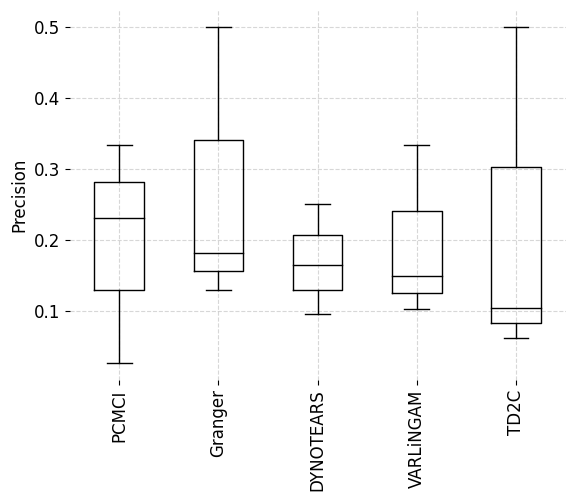

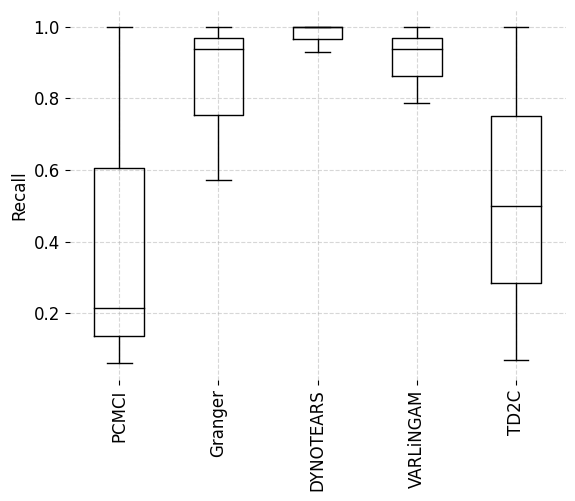

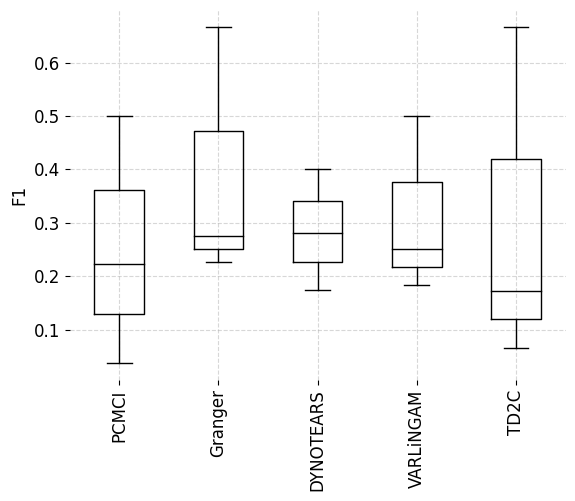

In [7]:
from matplotlib import pyplot as plt

# boxplot for precisions
df_precision.boxplot(color='black')
# plt.title('Precision Boxplot')
plt.ylabel('Precision', fontsize=12)
plt.xticks(rotation=90)
# remove borders 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
# bigger labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# grid in -- style and alpha = 0.5
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()


# boxplot for recalls
df_recall.boxplot(color='black')
# plt.title('Precision Boxplot')
plt.ylabel('Recall', fontsize=12)
plt.xticks(rotation=90)
# remove borders 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
# bigger labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# grid in -- style and alpha = 0.5
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


# boxplot for f1s
df_f1.boxplot(color='black')
# plt.title('Precision Boxplot')
plt.ylabel('F1', fontsize=12)
plt.xticks(rotation=90)
# remove borders 
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
# bigger labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# grid in -- style and alpha = 0.5
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()



# BIGGEST DATASETS


# BENCHMARKING